### Forecasting equity risk premiums

Last updated: 2024/07/05

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data loading and processing

14 monthly macroeconomic predictors (ECON) from Welch and Goyal (2008)

In [2]:
# from Amit Goyal's website: https://sites.google.com/view/agoyal145

# from local
df = pd.read_excel('C:/Users/11120/Documents/Python/data/PredictorData2023.xlsx',
                   sheet_name='dataset', index_col='Date')

In [3]:
# 1. Dividend Price Ratio (d/p): the difference between the log of dividends and the log of prices.
df['d/p'] = np.log(df['D12']) - np.log(df['Index'])

# 2. Dividend Yield (d/y): the difference between the log of dividends and the log of lagged prices.
df['d/y'] = np.log(df['D12']) - np.log(df['Index'].shift(1))

# 3. Earnings Price Ratio (e/p): the difference between the log of earnings and the log of prices.
df['e/p'] = np.log(df['E12']) - np.log(df['Index'])

# 4. Dividend Payout Ratio (d/e): the difference between the log of dividends and the log of earnings.
df['d/e'] = np.log(df['D12']) - np.log(df['E12'])

# 5. Stock Variance (svar): the sum of squared daily returns on the S&P 500.

# 6. Book-to-Market Ratio (b/m): the ratio of book value to market value for the Dow Jones Industrial Average.

# 7. Net Equity Expansion (ntis): the ratio of 12-month moving sums of net issues by NYSE listed stocks divided by the total end-of-year market capitalization of NYSE stocks.

# 8. Treasury Bills (tbl): the 3-month Treasury-bill rate.

# 9. Long Term Yield (lty): the long-term government bond yield.

# 10. Long Term Rate of Returns (ltr): the long-term government bond return.

# 11. Term Spread (tms): the difference between the long term yield on government bonds and the Treasury-bill.
df['tms'] = df['lty'] - df['tbl']

# 12. Default Yield Spread (dfy): the difference between BAA and AAA-rated corporate bond yields.
df['dfy'] = df['BAA'] - df['AAA']

# 13. Default Return Spread (dfr): the difference between long-term corporate bond and long-term government bond returns.
df['dfr'] = df['corpr'] - df['ltr']

# 14. Inflation (infl): the Consumer Price Index (All Urban Consumers) with a 1-month lag.
df['infl'] = df['infl'].shift(1)

In [4]:
# some predictors (ntis, tbl, lty, and infl) are signed
# such that their coefficients are expected to be positive based on theory
# (Campbell and Thomson 2008).

df['ntis-'] = df['ntis'] * -1
df['tbl-'] = df['tbl'] * -1
df['lty-'] = df['lty'] * -1
df['infl-'] = df['infl'] * -1

14 monthly technical indicators (TECH) from Neely et al. (2014)

In [5]:
import yfinance as yf

sp500 = yf.download('^GSPC', proxy='http://46.2.90.210:8080').rename(columns=str.lower)

sp_price = sp500['adj close'].resample('M').last()
sp_volume = sp500['volume'].astype('float').resample('M').sum().div(1000000)
sp_obv = (sp_volume * np.where(sp_price.pct_change() >= 0, 1, -1)).cumsum()

[*********************100%***********************]  1 of 1 completed


In [6]:
# 1~6. Moving-average (MA)
for s in [1,2,3]:
    for l in [9,12]:
        df[f'ma({s},{l})'] = (sp_price.rolling(s).mean() / sp_price.rolling(l).mean())\
        .apply(lambda x: 1 if x >= 1 else 0)

# 7~8. Momentum (MOM)
for m in [9,12]:
    df[f'mom({m})'] = (sp_price / sp_price.shift(m))\
    .apply(lambda x: 1 if x >= 1 else 0)

# 9~14. On-balance volume (VOL)
for s in [1,2,3]:
    for l in [9,12]:
        df[f'vol({s},{l})'] = (sp_obv.rolling(s).mean() / sp_obv.rolling(l).mean())\
        .apply(lambda x: 1 if x >= 1 else 0)

Dependent variable (the equity risk premium) and the benchmark

In [7]:
# (Simple) Equity Risk Premium (erp): the total return on the stock market minus the return on a risk-free bill.
df['erp'] = df['CRSP_SPvw'] - df['Rfree']

# # (Log) Equity Risk Premium (erp): the log return on the stock market minus the log return on a risk-free bill.
# df['CRSP_SPvw'] = np.log1p(df['CRSP_SPvw'])
# df['Rfree'] = np.log1p(df['Rfree'])
# df['erp'] = df['CRSP_SPvw'] - df['Rfree']

# Equity Risk Premium for T+1 (target).
df['target'] = df['erp'].shift(-1)

# Benchmark (bench): the historical average of the equity risk premium.
df['bench'] = df['erp'].expanding(min_periods=1).mean()

# Sum-of-the-parts (sop): the Ferreira and Santa-Clara (2011)'s sum-of-the-parts method.
df['sotp'] = df['E12'].pct_change().rolling(20*12).mean() + (df['D12'] / df['Index'])/12 - df['tbl']/12

# Sample variance (hvar) of the 'erp' for the asset allocation exercise using a five-year rolling estimation window.
df['hvar'] = df['erp'].rolling(5*12).var()
df['hvar'].fillna(df['hvar'].mean(), inplace=True)

Additional data for analysis

In [8]:
import requests

proxies = {'http': 'http://46.2.90.210:8080', 'https': 'http://46.2.90.210:8080'}
s = requests.Session()
s.proxies.update(proxies)

In [9]:
import pandas_datareader.data as web

# NBER recession data from FRED
nber = web.DataReader(['USRECD'], 'fred',
                      start='1927-01-01',
                      session=s
                      )
nber = nber.resample('M').last().ffill()

# Fama-French 5-factor (FF5) data from Ken French's website
ff5_dict = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench',
                          start='1927-01-01',
                          session=s
                          )
ff5 = ff5_dict[0].div(100).rename(columns={'Mkt-RF':'MKT'}).drop(['RF'], axis=1)
ff5.index = ff5.index.astype('datetime64[ns]')
ff5 = ff5.resample('M').last()

Sample dataset

In [10]:
df = df[[
    'erp','target','bench','sotp','hvar',
    'd/p','d/y','e/p','d/e','svar','b/m','ntis-','tbl-','lty-','ltr','tms','dfy','dfr','infl-',
    'ma(1,9)','ma(1,12)','ma(2,9)','ma(2,12)','ma(3,9)','ma(3,12)','mom(9)','mom(12)',
    'vol(1,9)','vol(1,12)','vol(2,9)','vol(2,12)','vol(3,9)','vol(3,12)'
    ]]['1951':]
df

,erp,target,bench,sotp,hvar,d/p,d/y,e/p,d/e,svar,...,"ma(3,9)","ma(3,12)",mom(9),mom(12),"vol(1,9)","vol(1,12)","vol(2,9)","vol(2,12)","vol(3,9)","vol(3,12)"
Date,,,,,,,,,,,,,,,,,,,,,
1951-01-31,0.063805,0.013546,0.008025,0.009688,0.001777,-2.678929,-2.619486,-2.032836,-0.646092,0.001705,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1951-02-28,0.013546,-0.018584,0.008043,0.009827,0.001685,-2.674227,-2.667785,-2.040457,-0.633770,0.000651,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1951-03-31,-0.018584,0.047808,0.007956,0.010098,0.001670,-2.644681,-2.663200,-2.023114,-0.621566,0.001228,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1951-04-30,0.047808,-0.031179,0.008087,0.009906,0.001684,-2.682958,-2.635949,-2.083165,-0.599793,0.000848,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1951-05-31,-0.031179,-0.027048,0.007958,0.010224,0.001702,-2.632879,-2.674295,-2.054959,-0.577919,0.001407,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,-0.019924,-0.051866,0.006830,0.007204,0.002953,-4.177780,-4.195655,-3.203119,-0.974661,0.001337,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2023-09-30,-0.051866,-0.025740,0.006780,0.007131,0.003015,-4.124953,-4.174899,-3.147294,-0.977659,0.001023,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2023-10-31,-0.025740,0.086404,0.006752,0.006847,0.002929,-4.097976,-4.120201,-3.110379,-0.987597,0.001678,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0


In [11]:
all_predictor = df.columns[5:].to_list()
econ_predictor = df.columns[5:19].to_list()
tech_predictor = df.columns[19:].to_list()

In [12]:
df_nber = df.join(nber)

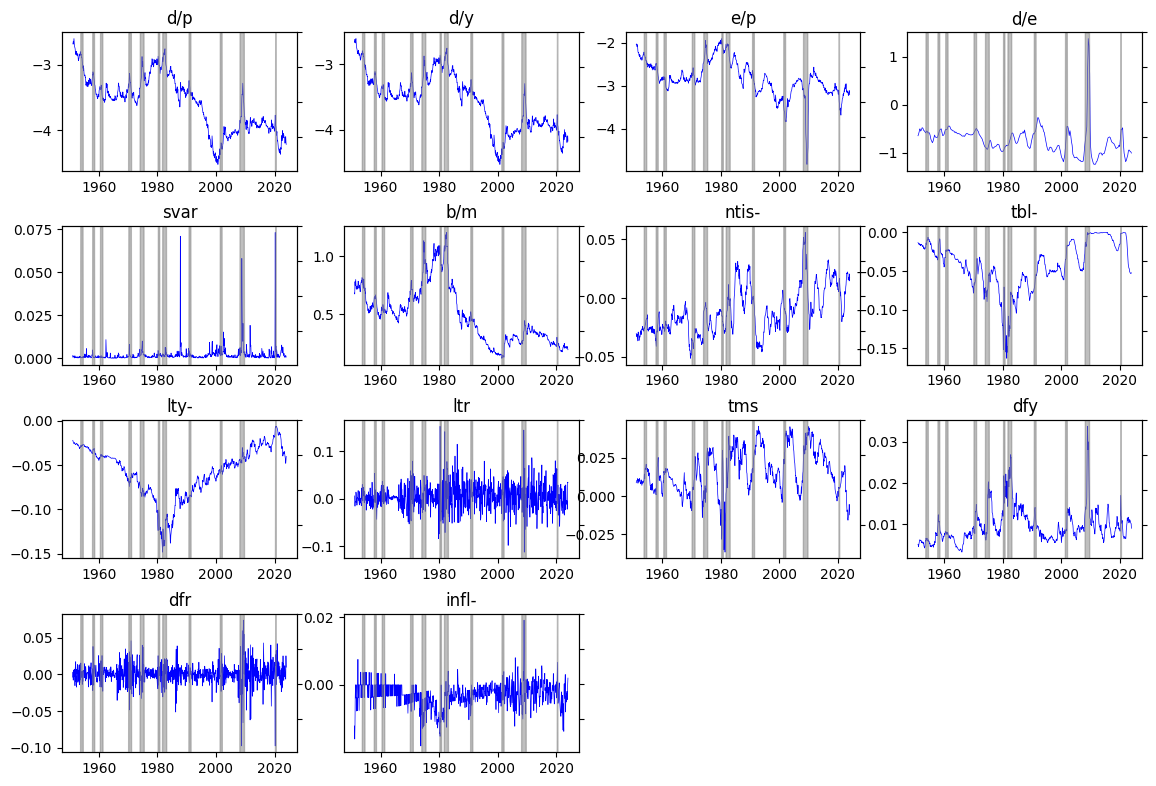

In [13]:
import matplotlib.dates as mdates

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(12, 8))
axs = axs.flatten()
for i, pred in enumerate(econ_predictor):
    ax = axs[i]
    ax.plot(df_nber.index, df_nber[pred], color='blue', linewidth=0.5)
    ax.set_title(pred)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=20))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax2 = ax.twinx()
    ax2.fill_between(df_nber.index, df_nber['USRECD'], color='grey', alpha=0.5)
    ax2.set_ylim(0.01,1)
    ax2.set_yticklabels([])
for j in range(len(econ_predictor), 16):
    fig.delaxes(axs[j])
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.2, hspace=0.4)

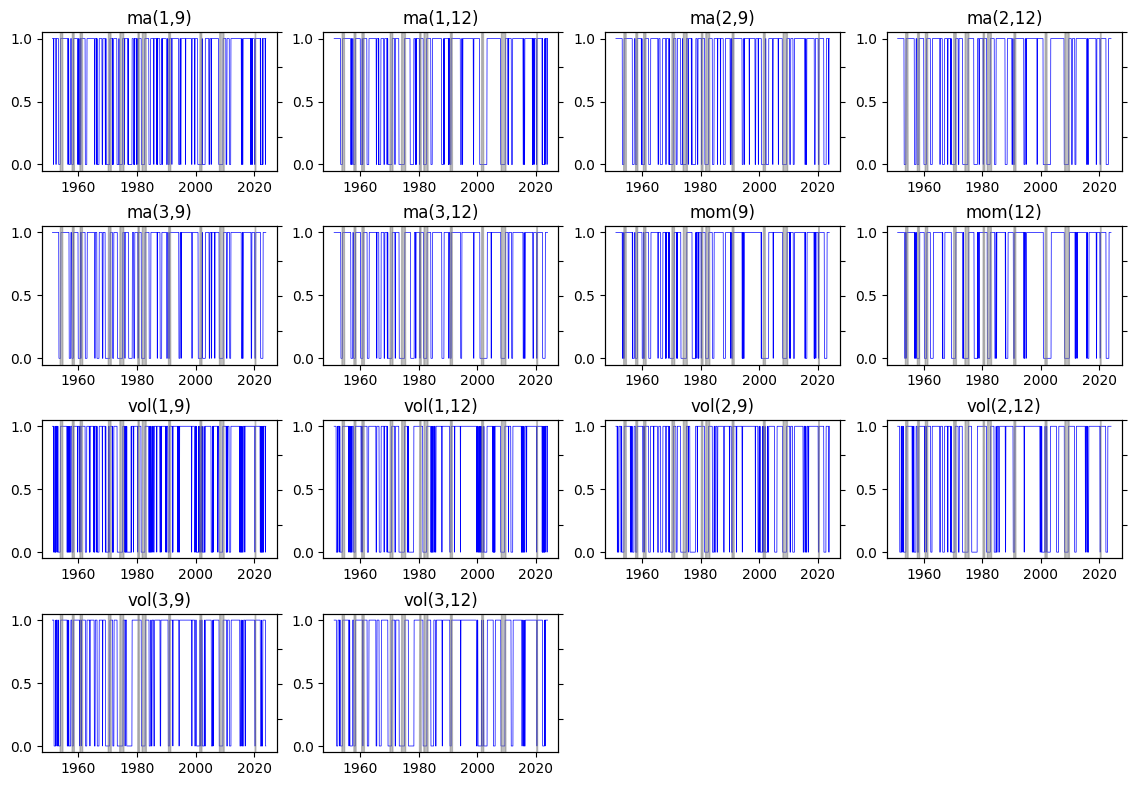

In [14]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(12, 8))
axs = axs.flatten()
for i, pred in enumerate(tech_predictor):
    ax = axs[i]
    ax.plot(df_nber.index, df_nber[pred], color='blue', linewidth=0.5)
    ax.set_title(pred)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=20))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax2 = ax.twinx()
    ax2.fill_between(df_nber.index, df_nber['USRECD'], color='grey', alpha=0.5)
    ax2.set_ylim(0.01,1)
    ax2.set_yticklabels([])
for j in range(len(tech_predictor), 16):
    fig.delaxes(axs[j])
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.2, hspace=0.4)
#fig.tight_layout()

### Performance measures

Statistical significance

In [15]:
import statsmodels.api as sm

def calc_oos_r2(y_true, y_pred, y_hist):
    '''
    Campbell and Thompson (2008) out-of-sample R^2 statistic.
    '''
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_hist = np.array(y_hist)

    numerator = np.sum((y_true - y_pred)**2)
    denominator = np.sum((y_true - y_hist)**2)

    r2_os = 1 - (numerator / denominator)
    return r2_os

def calc_msfe_adj(y_true, y_pred, y_hist):
    '''
    Clark and West (2007) MSFE-adjusted statistic.
    '''
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_hist = np.array(y_hist)

    e1 = y_true - y_hist
    e2 = y_true - y_pred
    f_t = e1**2 - (e2**2 - (y_hist - y_pred)**2)

    X = np.ones(len(f_t))
    model = sm.OLS(f_t, X).fit()
    t_stat = model.tvalues[0]
    if t_stat > 0:
        p_val_one_sided = model.pvalues[0]/2
    else:
        p_val_one_sided = 1 - model.pvalues[0]/2
    return t_stat, p_val_one_sided

Economic value

In [16]:
def calc_opt_weight(y_pred, y_variance, risk_aversion=3):
    '''
    Mean-variance investor's optimal allocation to the stock market.
    '''
    weight = np.clip((1/risk_aversion)*(y_pred/y_variance), 0.0, 1.5)
    return weight

def calc_strategy_return(y_true, y_pred, y_variance, risk_aversion=3, tcost=0.0):
    '''
    Calculate the excess returns of an asset allocation strategy.
    '''
    weight = calc_opt_weight(y_pred, y_variance, risk_aversion)

    strategy_return = weight.shift() * y_true.shift()
    strategy_return[0] = 0

    turnover = (weight - weight.shift()*((1+y_true.shift())/(1+strategy_return))).abs().div(2)
    turnover[0] = 0
    avg_turnover = turnover.mean()

    strategy_return_tcost = strategy_return - (turnover.shift()*tcost*2)
    strategy_return_tcost[0] = 0

    bnh_return = y_true.shift()
    bnh_return[0] = 0

    return strategy_return_tcost, avg_turnover, bnh_return

def calc_cer_gain(y_true, y_pred, y_hist, y_variance, risk_aversion=3, tcost=0.0):
    '''
    Average utility gain corresponding to using y_pred instead of y_hist.
    '''
    pred_return = calc_strategy_return(y_true, y_pred, y_variance, risk_aversion, tcost)[0]
    hist_return = calc_strategy_return(y_true, y_hist, y_variance, risk_aversion, tcost)[0]
    bnh_return = calc_strategy_return(y_true, y_hist, y_variance, risk_aversion, tcost)[2]

    pred_return_mean = np.mean(pred_return)
    pred_return_variance = np.var(pred_return)
    pred_return_cer = pred_return_mean - (risk_aversion/2)*pred_return_variance

    hist_return_mean = np.mean(hist_return)
    hist_return_variance = np.var(hist_return)
    hist_return_cer = hist_return_mean - (risk_aversion/2)*hist_return_variance

    bnh_return_mean = np.mean(bnh_return)
    bnh_return_variance = np.var(bnh_return)
    bnh_return_cer = bnh_return_mean - (risk_aversion/2)*bnh_return_variance

    return (pred_return_cer - hist_return_cer)*12, (bnh_return_cer - hist_return_cer)*12  # annualized

def calc_sharpe_gain(y_true, y_pred, y_hist, y_variance, risk_aversion=3, tcost=0.0):
    '''
    Increase in Sharpe ratio using y_pred instead of y_hist.
    '''
    pred_return = calc_strategy_return(y_true, y_pred, y_variance, risk_aversion, tcost)[0]
    hist_return = calc_strategy_return(y_true, y_hist, y_variance, risk_aversion, tcost)[0]
    bnh_return = calc_strategy_return(y_true, y_hist, y_variance, risk_aversion, tcost)[2]

    pred_return_mean = np.mean(pred_return)
    pred_return_std = np.std(pred_return)
    pred_return_sr = pred_return_mean / pred_return_std

    hist_return_mean = np.mean(hist_return)
    hist_return_std = np.std(hist_return)
    hist_return_sr = hist_return_mean / hist_return_std

    bnh_return_mean = np.mean(bnh_return)
    bnh_return_std = np.std(bnh_return)
    bnh_return_sr = bnh_return_mean / bnh_return_std

    return (pred_return_sr - hist_return_sr)*np.sqrt(12), (bnh_return_sr - hist_return_sr)*np.sqrt(12)

In [17]:
# import the custom module ('performance_measure')

# from local
import sys
sys.path.append('C:/Users/11120/Documents/Python/my_packages')
from utils.performance_measure import *

# __all__ = ['rebase',
#            'annual_factor',
#            'calc_nyears',
#            'calc_cagr',
#            'calc_mean',
#            'calc_robust_t',
#            'calc_vol',
#            'calc_skew',
#            'calc_kurt',
#            'calc_max',
#            'calc_min',
#            'calc_sharpe',
#            'calc_mdd',
#            'calc_te',
#            'calc_ir',
#            'roll_cagr',
#            'roll_mean',
#            'roll_vol',
#            'roll_sharpe',
#            'factor_reg',
#            'summary_stats',
#            ]

### Out-of-sample tests of return predictability

Simple linear: Bivariate predictive regression forecasts

In [18]:
from sklearn.linear_model import LinearRegression

initial_estimation_period = 15*12
#window_size = 15*12  # for rolling window estimation

pred = {}
for predictor in all_predictor:
    pred_ = []
    for i in range(initial_estimation_period, len(df)):
    #for i in range(window_size, len(df)):
        train_data = df.iloc[:i]
        #train_data = df.iloc[i-window_size:i]
        test_data  = df.iloc[i:i+1]

        y_train = train_data['target']

        x_train = train_data[predictor].values.reshape(-1,1)
        x_test = test_data[predictor].values.reshape(-1,1)

        model = LinearRegression().fit(x_train, y_train)
        if model.coef_[0] < 0:  # constrain the sign of the slope to be consistent with economic theory (Campbell and Thomson 2008).
            pred_.append([model.intercept_])
        else:
            pred_.append(model.predict(x_test))  # use this when no constraint

    pred[predictor] = pd.DataFrame(pred_, index=df[initial_estimation_period:].index, columns=[predictor])
    #pred[predictor] = pd.DataFrame(pred_, index=df[window_size:].index, columns=[predictor])

pred = pd.concat(pred.values(), axis=1)

Forecast combinations

In [19]:
pred['comb-econ'] = pred[econ_predictor].mean(axis=1)
pred['comb-tech'] = pred[tech_predictor].mean(axis=1)
pred['comb-all'] = pred[all_predictor].mean(axis=1)

Dimension reduction: PCR and PLS  

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

In [21]:
predictors = [econ_predictor,tech_predictor,all_predictor]
predictor_names = ['econ','tech','all']

In [22]:
### principal component regressions
for predictor, name in zip(predictors, predictor_names):
    pred_ = []
    for i in range(initial_estimation_period, len(df)):
    #for i in range(window_size, len(df)):
        train_data = df.iloc[:i]
        #train_data = df.iloc[i-window_size:i]
        test_data  = df.iloc[i:i+1]

        scaler = StandardScaler()
        pca = PCA(n_components=1)

        y_train = train_data['target']

        x_train = scaler.fit_transform(train_data[predictor].values)
        x_train = pca.fit_transform(x_train)
        x_test = scaler.transform(test_data[predictor].values)
        x_test = pca.transform(x_test)

        model = LinearRegression().fit(x_train, y_train)
        pred_.append(model.predict(x_test))

    pred[f'pc-{name}'] = pd.DataFrame(pred_, index=df[initial_estimation_period:].index)
    #pred[f'pc-{name}'] = pd.DataFrame(pred_, index=df[window_size:].index)

In [23]:
### partial least squares (PLS) regressions
for predictor, name in zip(predictors, predictor_names):
    pred_ = []
    for i in range(initial_estimation_period, len(df)):
    #for i in range(window_size, len(df)):
        train_data = df.iloc[:i]
        #train_data = df.iloc[i-window_size:i]
        test_data  = df.iloc[i:i+1]

        scaler = StandardScaler()

        y_train = train_data['target']

        x_train = scaler.fit_transform(train_data[predictor].values)
        x_test = scaler.transform(test_data[predictor].values)

        model = PLSRegression(n_components=1, scale=False).fit(x_train, y_train)
        pred_.append(model.predict(x_test)[0])

    pred[f'pls-{name}'] = pd.DataFrame(pred_, index=df[initial_estimation_period:].index)
    #pred[f'pls-{name}'] = pd.DataFrame(pred_, index=df[window_size:].index)

Penalized linear: LASSO, Ridge, and Elastic Net  

In [24]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [25]:
### lasso regressions
for predictor, name in zip(predictors, predictor_names):
    pred_ = []
    for i in range(initial_estimation_period, len(df)):
    #for i in range(window_size, len(df)):
        train_data = df.iloc[:i]
        #train_data = df.iloc[i-window_size:i]
        test_data  = df.iloc[i:i+1]

        scaler = StandardScaler()

        y_train = train_data['target']

        x_train = scaler.fit_transform(train_data[predictor].values)
        x_test = scaler.transform(test_data[predictor].values)

        model = Lasso()

        param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 10]}
        tscv = TimeSeriesSplit(n_splits=5)
        grid_search = GridSearchCV(model, param_grid=param_grid, cv=tscv,
                                   scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(x_train, y_train)
        pred_.append(grid_search.predict(x_test))

    pred[f'lasso-{name}'] = pd.DataFrame(pred_, index=df[initial_estimation_period:].index)
    #pred[f'lasso-{name}'] = pd.DataFrame(pred_, index=df[window_size:].index)

In [26]:
### ridge regressions
for predictor, name in zip(predictors, predictor_names):
    pred_ = []
    for i in range(initial_estimation_period, len(df)):
    #for i in range(window_size, len(df)):
        train_data = df.iloc[:i]
        #train_data = df.iloc[i-window_size:i]
        test_data  = df.iloc[i:i+1]

        scaler = StandardScaler()

        y_train = train_data['target']

        x_train = scaler.fit_transform(train_data[predictor].values)
        x_test = scaler.transform(test_data[predictor].values)

        model = Ridge()

        param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 10]}
        tscv = TimeSeriesSplit(n_splits=5)
        grid_search = GridSearchCV(model, param_grid=param_grid, cv=tscv,
                                   scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(x_train, y_train)
        pred_.append(grid_search.predict(x_test))

    pred[f'ridge-{name}'] = pd.DataFrame(pred_, index=df[initial_estimation_period:].index)
    #pred[f'ridge-{name}'] = pd.DataFrame(pred_, index=df[window_size:].index)

In [27]:
### elastic net regressions
for predictor, name in zip(predictors, predictor_names):
    pred_ = []
    for i in range(initial_estimation_period, len(df)):
    #for i in range(window_size, len(df)):
        train_data = df.iloc[:i]
        #train_data = df.iloc[i-window_size:i]
        test_data  = df.iloc[i:i+1]

        scaler = StandardScaler()

        y_train = train_data['target']

        x_train = scaler.fit_transform(train_data[predictor].values)
        x_test = scaler.transform(test_data[predictor].values)

        model = ElasticNet()

        param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 10],
                      'l1_ratio': [0.1, 0.5, 0.9]}
        tscv = TimeSeriesSplit(n_splits=5)
        grid_search = GridSearchCV(model, param_grid=param_grid, cv=tscv,
                                   scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(x_train, y_train)
        pred_.append(grid_search.predict(x_test))

    pred[f'enet-{name}'] = pd.DataFrame(pred_, index=df[initial_estimation_period:].index)
    #pred[f'enet-{name}'] = pd.DataFrame(pred_, index=df[window_size:].index)

Tree models: RF, ERT, and GBRT

In [28]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor

In [29]:
### random forest (RF) regressions
for predictor, name in zip(predictors, predictor_names):
    pred_ = []
    for i in range(initial_estimation_period, len(df)):
    #for i in range(window_size, len(df)):
        train_data = df.iloc[:i]
        #train_data = df.iloc[i-window_size:i]
        test_data  = df.iloc[i:i+1]

        y_train = train_data['target']
        x_train = train_data[predictor]
        x_test = test_data[predictor]

        model = RandomForestRegressor()

        param_grid = {
            'n_estimators': [100, 300],  # default=100
            'max_depth': [2, 3],  # default=None
            'max_features': [1.0, 'sqrt']  # default=1.0 (max_features=n_features)
        }

        tscv = TimeSeriesSplit(n_splits=5)
        grid_search = GridSearchCV(model, param_grid=param_grid, cv=tscv,
                                   scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(x_train, y_train)
        pred_.append(grid_search.predict(x_test))

    pred[f'rf-{name}'] = pd.DataFrame(pred_, index=df[initial_estimation_period:].index)
    #pred[f'rf-{name}'] = pd.DataFrame(pred_, index=df[window_size:].index)

In [30]:
### extremely randomized trees (ERT) regressions
for predictor, name in zip(predictors, predictor_names):
    pred_ = []
    for i in range(initial_estimation_period, len(df)):
    #for i in range(window_size, len(df)):
        train_data = df.iloc[:i]
        #train_data = df.iloc[i-window_size:i]
        test_data  = df.iloc[i:i+1]

        y_train = train_data['target']
        x_train = train_data[predictor]
        x_test = test_data[predictor]

        model = ExtraTreesRegressor()

        param_grid = {
            'n_estimators': [100, 300],  # default=100
            'max_depth': [2, 3],  # default=None
            'max_features': [1.0, 'sqrt']  # default=1.0 (max_features=n_features)
        }

        tscv = TimeSeriesSplit(n_splits=5)
        grid_search = GridSearchCV(model, param_grid=param_grid, cv=tscv,
                                   scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(x_train, y_train)
        pred_.append(grid_search.predict(x_test))

    pred[f'ert-{name}'] = pd.DataFrame(pred_, index=df[initial_estimation_period:].index)
    #pred[f'ert-{name}'] = pd.DataFrame(pred_, index=df[window_size:].index)

In [31]:
### gradient boosted regression trees (GBRT)
for predictor, name in zip(predictors, predictor_names):
    pred_ = []
    for i in range(initial_estimation_period, len(df)):
    #for i in range(window_size, len(df)):
        train_data = df.iloc[:i]
        #train_data = df.iloc[i-window_size:i]
        test_data  = df.iloc[i:i+1]

        y_train = train_data['target']
        x_train = train_data[predictor]
        x_test = test_data[predictor]

        model = GradientBoostingRegressor()

        param_grid = {
            'n_estimators': [100, 500],  # default=100
            'learning_rate': [0.01, 0.1],  # default=0.1
            'max_depth': [2, 3],  # default=3
            'max_features': [None, 'sqrt']  # default=None (max_features=n_features)
        }

        tscv = TimeSeriesSplit(n_splits=5)
        grid_search = GridSearchCV(model, param_grid=param_grid, cv=tscv,
                                   scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(x_train, y_train)
        pred_.append(grid_search.predict(x_test))

    pred[f'gbrt-{name}'] = pd.DataFrame(pred_, index=df[initial_estimation_period:].index)
    #pred[f'gbrt-{name}'] = pd.DataFrame(pred_, index=df[window_size:].index)

### Out-of-sample forecasting results

Empirical results

In [32]:
pred = pred.join(df[['sotp','bench','target','hvar']])

In [33]:
strategies = pred.columns[:-2].to_list()  # excl. 'target' and 'hvar'
strategies_plus_bnh = strategies + ['bnh']  # the buy-and-hold strategy

y_true = pred['target']
y_hist = pred['bench']
y_variance = pred['hvar']
risk_aversion = 3
tcost = 0.0

res_r2 = []
res_msfe_tval = []
res_msfe_pval = []
res_cer_gain = []
res_sharpe_gain = []
res_to = []
res_pf = []
res_wgt = []

for strat in strategies:
    y_pred = pred[strat]
    r2 = calc_oos_r2(y_true[:-1], y_pred[:-1], y_hist[:-1])
    msfe_tval, msfe_pval = calc_msfe_adj(y_true[:-1], y_pred[:-1], y_hist[:-1])
    cer_gain = calc_cer_gain(y_true, y_pred, y_hist, y_variance, risk_aversion, tcost)[0]
    sharpe_gain = calc_sharpe_gain(y_true, y_pred, y_hist, y_variance, risk_aversion, tcost)[0]
    to = calc_strategy_return(y_true, y_pred, y_variance, risk_aversion, tcost)[1]
    pf = np.cumprod(1+calc_strategy_return(y_true, y_pred, y_variance, risk_aversion, tcost)[0])*100
    wgt = calc_opt_weight(y_pred, y_variance, risk_aversion)

    res_r2.append(r2)
    res_msfe_tval.append(msfe_tval)
    res_msfe_pval.append(msfe_pval)
    res_cer_gain.append(cer_gain)
    res_sharpe_gain.append(sharpe_gain)
    res_to.append(to)
    res_pf.append(pf)
    res_wgt.append(wgt)

# for 'bnh'
res_r2.append(np.nan)
res_msfe_tval.append(np.nan)
res_msfe_pval.append(np.nan)
res_cer_gain.append(calc_cer_gain(y_true, y_pred, y_hist, y_variance, risk_aversion, tcost)[1])
res_sharpe_gain.append(calc_sharpe_gain(y_true, y_pred, y_hist, y_variance, risk_aversion, tcost)[1])
res_to.append(np.nan)
res_pf.append(np.cumprod(1+calc_strategy_return(y_true, y_pred, y_variance, risk_aversion, tcost)[2])*100)
res_wgt.append(pd.Series(1., index=wgt.index))

res_r2 = pd.DataFrame(res_r2, index=strategies_plus_bnh, columns=['r2_oos'])
res_msfe_tval = pd.DataFrame(res_msfe_tval, index=strategies_plus_bnh, columns=['msfe_tval'])
res_msfe_pval = pd.DataFrame(res_msfe_pval, index=strategies_plus_bnh, columns=['msfe_pval'])
res_cer_gain = pd.DataFrame(res_cer_gain, index=strategies_plus_bnh, columns=['cer_gain'])
res_sharpe_gain = pd.DataFrame(res_sharpe_gain, index=strategies_plus_bnh, columns=['sharpe_gain'])
res_to = pd.DataFrame(res_to, index=strategies_plus_bnh, columns=['avg_turnover'])

result ={'all': pd.concat([res_r2,res_msfe_tval,res_msfe_pval,res_cer_gain,res_sharpe_gain,res_to], axis=1)}
pf_indices = pd.concat(res_pf, axis=1)
pf_indices.columns = strategies_plus_bnh
pf_wgts = pd.concat(res_pf, axis=1)
pf_wgts.columns = strategies_plus_bnh

In [42]:
np.round(pd.concat(result, axis=1),4)[('all','r2_oos')].sort_values(ascending=False)[:10]

sotp         0.0093
comb-econ    0.0075
pc-econ      0.0066
comb-all     0.0043
vol(3,12)    0.0029
ma(2,12)     0.0022
pls-all      0.0018
ltr          0.0011
bench        0.0000
ma(1,12)    -0.0002
Name: (all, r2_oos), dtype: float64

In [43]:
np.round(pd.concat(result, axis=1),4)[('all','cer_gain')].sort_values(ascending=False)[:10]

pls-all       0.0360
ridge-all     0.0359
pls-econ      0.0333
ridge-econ    0.0295
tms           0.0256
ma(2,12)      0.0256
sotp          0.0239
pls-tech      0.0221
ma(1,12)      0.0219
pc-all        0.0206
Name: (all, cer_gain), dtype: float64

In [44]:
np.round(pd.concat(result, axis=1),4)[('all','sharpe_gain')].sort_values(ascending=False)[:10]

pls-econ      0.2312
pls-all       0.2084
ridge-all     0.2037
ridge-econ    0.1604
tms           0.1355
ma(2,12)      0.1349
sotp          0.1306
pls-tech      0.1130
ma(1,12)      0.1114
pc-all        0.1035
Name: (all, sharpe_gain), dtype: float64

In [45]:
pd.set_option('display.max_columns', None)
summary_stats(pf_indices, factor_ret=ff5)

,d/p,d/y,e/p,d/e,svar,b/m,ntis-,tbl-,lty-,ltr,tms,dfy,dfr,infl-,"ma(1,9)","ma(1,12)","ma(2,9)","ma(2,12)","ma(3,9)","ma(3,12)",mom(9),mom(12),"vol(1,9)","vol(1,12)","vol(2,9)","vol(2,12)","vol(3,9)","vol(3,12)",comb-econ,comb-tech,comb-all,pc-econ,pc-tech,pc-all,pls-econ,pls-tech,pls-all,lasso-econ,lasso-tech,lasso-all,ridge-econ,ridge-tech,ridge-all,enet-econ,enet-tech,enet-all,rf-econ,rf-tech,rf-all,ert-econ,ert-tech,ert-all,gbrt-econ,gbrt-tech,gbrt-all,sotp,bench,bnh
nyears,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425,57.953425
nsamples,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695,695
cagr,0.021827,0.023181,0.044105,0.04205,0.054536,0.040642,0.057555,0.063945,0.054811,0.061531,0.076495,0.054027,0.051412,0.04823,0.050531,0.064869,0.056861,0.069368,0.061502,0.04961,0.049301,0.049885,0.048163,0.055946,0.054237,0.053099,0.049663,0.063288,0.061624,0.056876,0.056941,0.055171,0.06398,0.063937,0.065434,0.064495,0.076395,0.035117,0.048059,0.039863,0.072695,0.052998,0.078511,0.044875,0.051565,0.048324,0.056034,0.060831,0.0587,0.058236,0.06194,0.062263,0.050141,0.054229,0.052172,0.061013,0.05197,0.055379
mean,0.032908,0.033485,0.056879,0.054388,0.071705,0.055844,0.074047,0.075117,0.064681,0.075147,0.090492,0.071111,0.064341,0.060971,0.062668,0.075886,0.068694,0.080383,0.073386,0.062569,0.061733,0.062619,0.060974,0.068462,0.06701,0.066072,0.063144,0.07573,0.073328,0.069129,0.069221,0.06579,0.075594,0.07526,0.070354,0.075303,0.084998,0.048755,0.061417,0.05322,0.082546,0.065854,0.087453,0.056373,0.063986,0.059555,0.067432,0.073222,0.069366,0.069849,0.074359,0.073489,0.06199,0.066814,0.063928,0.069114,0.068696,0.065824
mean-t-stat,1.554208,1.64643,2.507506,2.417832,2.666608,2.227609,2.788864,3.208453,2.909046,3.383026,3.654922,2.644853,2.616711,2.525838,2.744168,3.587117,3.204301,3.878968,3.320007,2.739549,2.70981,2.705006,2.655271,2.995873,2.883352,2.741268,2.690327,3.442271,3.125869,3.107973,2.948587,3.083203,3.52618,3.537289,4.023368,3.595337,4.406771,2.013233,2.592371,2.1889,3.633491,2.920066,3.960073,2.589824,2.856098,2.752565,3.062546,3.225926,3.4642,3.160888,3.289649,3.437622,2.812077,2.901809,2.877246,3.351911,2.560081,3.17546
vol,0.149658,0.145007,0.163925,0.15911,0.190259,0.176994,0.187009,0.159638,0.148192,0.174292,0.179932,0.189521,0.166556,0.164088,0.160259,0.158482,0.160555,0.160009,0.162553,0.165017,0.162088,0.164145,0.163748,0.164413,0.165388,0.16633,0.167977,0.166473,0.161909,0.162937,0.16331,0.152879,0.161493,0.159807,0.117524,0.156731,0.147587,0.167492,0.167521,0.166512,0.156386,0.165734,0.153119,0.156796,0.163326,0.15581,0.158219,0.165159,0.154705,0.15917,0.16566,0.158694,0.159138,0.164431,0.158843,0.138768,0.186946,0.152958
skew,-0.178317,-0.020382,-0.498187,-1.007825,-0.567308,-0.483538,-0.663135,-0.599197,-0.681732,-0.181715,-0.611013,-0.595225,-0.565011,-0.718925,-0.983112,-0.735501,-0.84083,-0.757547,-0.742534,-0.916222,-0.863419,-0.815909,-0.924735,-0.809881,-0.828792,-0.837126,-0.929247,-0.71774,-0.686873,-0.901774,-0.874803,-0.77462,-0.853292,-0.825618,0.548803,-0.876276,-0.733381,-0.317521,-0.754561,-0.435851,0.08089,-0.721375,0.152622,-0.243094,-0.650589,-0.33957,-0.676203,-0.811017,-0.599824,-1.022471,-0.8072,-0.808995,-0.760872,-0.788335,-0.864437,-0.463013,-0.6864,-0.403632
kurt,5.787967,5.456194,2.498232,7.5924

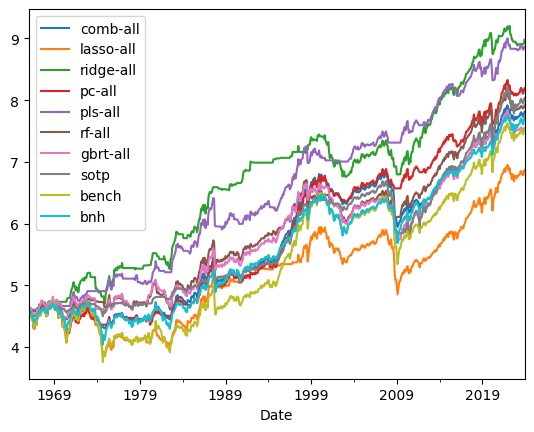

In [65]:
selected = ['comb-all','lasso-all','ridge-all','pc-all','pls-all','rf-all','gbrt-all','sotp','bench','bnh']
np.log(pf_indices[selected]).plot();

Return predictability over the business cycle

In [48]:
pred_ = pred.join(nber.shift(-1))
pred_expansion = pred_[pred_['USRECD']==0].drop(columns='USRECD')
pred_recession = pred_[pred_['USRECD']==1].drop(columns='USRECD')

In [49]:
y_true = pred_expansion['target']
y_hist = pred_expansion['bench']
y_variance = pred_expansion['hvar']
risk_aversion = 3
tcost = 0.0

res_r2 = []
res_msfe_tval = []
res_msfe_pval = []
res_cer_gain = []
res_sharpe_gain = []

for strat in strategies:
    y_pred = pred_expansion[strat]
    r2 = calc_oos_r2(y_true[:-1], y_pred[:-1], y_hist[:-1])
    msfe_tval, msfe_pval = calc_msfe_adj(y_true[:-1], y_pred[:-1], y_hist[:-1])
    cer_gain = calc_cer_gain(y_true, y_pred, y_hist, y_variance, risk_aversion, tcost)[0]
    sharpe_gain = calc_sharpe_gain(y_true, y_pred, y_hist, y_variance, risk_aversion, tcost)[0]

    res_r2.append(r2)
    res_msfe_tval.append(msfe_tval)
    res_msfe_pval.append(msfe_pval)
    res_cer_gain.append(cer_gain)
    res_sharpe_gain.append(sharpe_gain)

# for 'bnh'
res_r2.append(np.nan)
res_msfe_tval.append(np.nan)
res_msfe_pval.append(np.nan)
res_cer_gain.append(calc_cer_gain(y_true, y_pred, y_hist, y_variance, risk_aversion, tcost)[1])
res_sharpe_gain.append(calc_sharpe_gain(y_true, y_pred, y_hist, y_variance, risk_aversion, tcost)[1])

res_r2 = pd.DataFrame(res_r2, index=strategies_plus_bnh, columns=['r2_oos'])
res_msfe_tval = pd.DataFrame(res_msfe_tval, index=strategies_plus_bnh, columns=['msfe_tval'])
res_msfe_pval = pd.DataFrame(res_msfe_pval, index=strategies_plus_bnh, columns=['msfe_pval'])
res_cer_gain = pd.DataFrame(res_cer_gain, index=strategies_plus_bnh, columns=['cer_gain'])
res_sharpe_gain = pd.DataFrame(res_sharpe_gain, index=strategies_plus_bnh, columns=['sharpe_gain'])

result['expansion'] = pd.concat([res_r2,res_msfe_tval,res_msfe_pval,res_cer_gain,res_sharpe_gain], axis=1)

In [50]:
y_true = pred_recession['target']
y_hist = pred_recession['bench']
y_variance = pred_recession['hvar']
risk_aversion = 3
tcost = 0.0

res_r2 = []
res_msfe_tval = []
res_msfe_pval = []
res_cer_gain = []
res_sharpe_gain = []

for strat in strategies:
    y_pred = pred_recession[strat]
    r2 = calc_oos_r2(y_true, y_pred, y_hist)
    msfe_tval, msfe_pval = calc_msfe_adj(y_true, y_pred, y_hist)
    cer_gain = calc_cer_gain(y_true, y_pred, y_hist, y_variance, risk_aversion, tcost)[0]
    sharpe_gain = calc_sharpe_gain(y_true, y_pred, y_hist, y_variance, risk_aversion, tcost)[0]

    res_r2.append(r2)
    res_msfe_tval.append(msfe_tval)
    res_msfe_pval.append(msfe_pval)
    res_cer_gain.append(cer_gain)
    res_sharpe_gain.append(sharpe_gain)

# for 'bnh'
res_r2.append(np.nan)
res_msfe_tval.append(np.nan)
res_msfe_pval.append(np.nan)
res_cer_gain.append(calc_cer_gain(y_true, y_pred, y_hist, y_variance, risk_aversion, tcost)[1])
res_sharpe_gain.append(calc_sharpe_gain(y_true, y_pred, y_hist, y_variance, risk_aversion, tcost)[1])

res_r2 = pd.DataFrame(res_r2, index=strategies_plus_bnh, columns=['r2_oos'])
res_msfe_tval = pd.DataFrame(res_msfe_tval, index=strategies_plus_bnh, columns=['msfe_tval'])
res_msfe_pval = pd.DataFrame(res_msfe_pval, index=strategies_plus_bnh, columns=['msfe_pval'])
res_cer_gain = pd.DataFrame(res_cer_gain, index=strategies_plus_bnh, columns=['cer_gain'])
res_sharpe_gain = pd.DataFrame(res_sharpe_gain, index=strategies_plus_bnh, columns=['sharpe_gain'])

result['recession'] = pd.concat([res_r2,res_msfe_tval,res_msfe_pval,res_cer_gain,res_sharpe_gain], axis=1)

In [51]:
result_summary = np.round(pd.concat(result, axis=1),4)
result_summary

all                                                        \
            r2_oos msfe_tval msfe_pval cer_gain sharpe_gain avg_turnover   
d/p        -0.0041    0.8765    0.1905  -0.0170     -0.1476       0.0242   
d/y        -0.0041    0.9432    0.1730  -0.0143     -0.1365       0.0336   
e/p        -0.0070   -0.3058    0.6201   0.0003     -0.0205       0.0197   
d/e        -0.0071    0.7633    0.2228   0.0001     -0.0256       0.0240   
svar       -0.0011   -0.3809    0.6483   0.0011      0.0094       0.0131   
b/m        -0.0103   -1.2259    0.8897  -0.0074     -0.0519       0.0182   
ntis-      -0.0087    0.3181    0.3752   0.0053      0.0285       0.0347   
tbl-       -0.0081    2.0432    0.0207   0.0206      0.1031       0.0192   
lty-       -0.0071    1.5246    0.0639   0.0154      0.0690       0.0143   
ltr         0.0011    1.9705    0.0246   0.0133      0.0637       0.2636   
tms        -0.0104    1.8252    0.0342   0.0256      0.1355       0.0412   
dfy        -0.0052   -0.1814    0.5719   0.0010      0.0078       0.0247   
dfr        -0.0049   -0.6335    0.7367   0.0064      0.0188       0.0649   
infl-      -0.0044    0.2815    0.3892   0.0043      0.0041       0.0907   
ma(1,9)    -0.0024    0.1834    0.4273   0.0078      0.0236       0.0619   
ma(1,12)   -0.0002    0.7312    0.2324   0.0219      0.1114       0.0619   
ma(2,9)    -0.0006    0.5899    0.2777   0.0137      0.0604       0.0581   
ma(2,12)    0.0022    1.0965    0.1366   0.0256      0.1349       0.0514   
ma(3,9)    -0.0006    0.8360    0.2017   0.0174      0.0840       0.0601   
ma(3,12)   -0.0030   -0.1061    0.5422   0.0054      0.0117       0.0373   
mom(9)     -0.0027   -0.1822    0.5723   0.0060      0.0134       0.0375   
mom(12)    -0.0026   -0.1757    0.5697   0.0059      0.0140       0.0335   
vol(1,9)   -0.0029    0.0537    0.4786   0.0045      0.0049       0.0804   
vol(1,12)  -0.0020    0.4372    0.3311   0.0116      0.0489       0.0815   
vol(2,9)   -0.0029    0.1463    0.4419   0.0097      0.0377       0.0534   
vol(2,12)  -0.0068   -0.7593    0.7760   0.0083      0.0298       0.0331   
vol(3,9)   -0.0037   -0.2502    0.5987   0.0045      0.0084       0.0406   
vol(3,12)   0.0029    1.1527    0.1247   0.0178      0.0874       0.0443   
comb-econ   0.0075    2.2887    0.0112   0.0177      0.0854       0.0452   
comb-tech  -0.0005    0.3948    0.3466   0.0130      0.0568       0.0447   
comb-all    0.0043    1.4007    0.0809   0.0129      0.0564       0.0384   
pc-econ     0.0066    2.2106    0.0137   0.0144      0.0629       0.0297   
pc-tech    -0.0002    0.6302    0.2644   0.0202      0.1006       0.0526   
pc-all     -0.0011    0.5338    0.2968   0.0206      0.1035       0.0495   
pls-econ   -0.0281    1.3714    0.0853   0.0333      0.2312       0.1356   
pls-tech   -0.0008    0.7260    0.2340   0.0221      0.1130       0.0661   
pls-all     0.0018    2.1507    0.0159   0.0360      0.2084       0.0937   
lasso-econ -0.0095    1.1312    0.1292  -0.0096     -0.0764       0.0862   
lasso-tech -0.0051   -0.4055    0.6574   0.0030     -0.0008       0.0520   
lasso-all  -0.0114    0.7940    0.2137  -0.0046     -0.0478       0.0734   
ridge-econ -0.0474    1.6899    0.0458   0.0295      0.1604       0.1383   
ridge-tech -0.0146    0.5826    0.2802   0.0084      0.0299       0.1362   
ridge-all  -0.0605    1.7879    0.0371   0.0359      0.2037       0.1759   
enet-econ  -0.0088    1.2747    0.1014   0.0032     -0.0079       0.1006   
enet-tech  -0.0048   -0.2474    0.5976   0.0077      0.0243       0.0540   
enet-all   -0.0064    1.2987    0.0972   0.0068      0.0148       0.0899   
rf-econ    -0.0338    0.1209    0.4519   0.0136      0.0587       0.1488   
rf-tech    -0.0021    0.5209    0.3013   0.0160      0.0759       0.0855   
rf-all     -0.0335   -0.1971    0.5781   0.0171      0.0809       0.1451   
ert-econ   -0.0276   -0.2800    0.6102   0.0155      0.0714       0.1074   
ert-tech   -0.0023    0.4876    0.3130   0.0169      0.0814    

In [64]:
np.round(result_summary.mean().loc[:,['r2_oos','cer_gain','sharpe_gain']],4)

all        r2_oos        -0.0087
expansion  r2_oos        -0.0121
recession  r2_oos         0.0002
all        cer_gain       0.0112
expansion  cer_gain      -0.0058
recession  cer_gain       0.1374
all        sharpe_gain    0.0483
expansion  sharpe_gain   -0.0272
recession  sharpe_gain    0.1866
dtype: float64